# 確率勾配法を用いた2層ネットワークの実装

2次元データの3クラス分類問題を解く2層ネットワークを実装する．
ここではサンプルを1つづつ用いる確率勾配法を実装する．

# 準備

In [1]:
# load modules

import numpy as np

# !pip install scikit-image==0.12.3
# import skimage.data

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline
# plt.gray();
plt.set_cmap(plt.cm.Paired);

import sklearn
# from sklearn.datasets import fetch_olivetti_faces
from sklearn.datasets import make_blobs

from ipywidgets import interact, interactive, fixed, RadioButtons
import ipywidgets as widgets
from IPython.display import display

!pip install autograd
import autograd.numpy as anp # autogradのnumpyの別名をanpにする
# from autograd import elementwise_grad as grad
from autograd import grad
from autograd import jacobian, hessian

<Figure size 432x288 with 0 Axes>

In [2]:
# check versions

print("sklearn version :", sklearn.__version__, " >= 0.18.0")
# print("skimage version :", skimage.__version__, " >= 0.12.0")
print("numpy version :", np.__version__, " >= 0.12.0")
print("matplotlib version:", matplotlib.__version__, ">= 2.0.0")

sklearn version : 0.22.1  >= 0.18.0
numpy version : 1.18.1  >= 0.12.0
matplotlib version: 3.1.3 >= 2.0.0


# データセットの準備

sklearnのmake_blobで2次元データを準備する．
返り値は，データXとラベルyである．3クラスの場合，ラベルyは0,1,2で返ってくる．

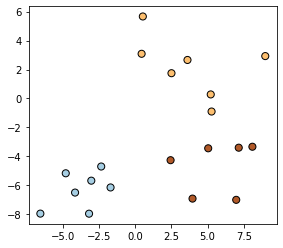

In [3]:
X, y = make_blobs(n_samples=20, # 20個生成
                  n_features=2, # 2次元
                  centers=3,    # クラスタ中心2個
                  cluster_std = 2 # クラスタの大きさ（標準偏差）
                 )

X = np.hstack((X, np.ones((X.shape[0], 1)))) # 同次座標

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolors='k');
plt.gca().set_aspect('equal');

0,1,2のラベルyをone-hotエンコードに変更する．

In [4]:
y # これは0,12

array([2, 0, 0, 0, 0, 2, 2, 1, 2, 0, 0, 1, 1, 0, 1, 2, 2, 1, 1, 1])

In [5]:
from sklearn.preprocessing import OneHotEncoder

In [6]:
Y = OneHotEncoder(categories='auto').fit_transform(y.reshape(-1,1)).toarray()
Y # これでone-hotになっている

array([[0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

識別境界を直線で描くヘルパー関数の準備．

In [7]:
# 境界線を引く関数の定義

def plotBoundary(X, net, w, mesh=True, n_neighbors=1):

    # plot range
    x_min = min(X[:,0])
    x_max = max(X[:,0])
    y_min = min(X[:,1])
    y_max = max(X[:,1])

    # visualizing decision function
    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j] # make a grid
    Z = np.zeros((XX.size, X.shape[1]))
    for i,xi in enumerate(np.c_[XX.ravel(), YY.ravel(), np.ones(XX.size)]):
        Z[i] = net(w, xi)
    Z = np.argmax(Z, axis=1) # --> 0,1,2
    Z = Z.reshape(XX.shape) # just reshape

    if mesh:
        plt.pcolormesh(XX, YY, Z, zorder=-10) # paint in 2 colors, if Z > 0 or not

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    

# 2層ネットワークの実装


以下の2層ネットワークは，活性化関数をReLUやsigmoidなどにした例である． 第1層では入力の3次元を線形変換で6次元の中間層にして活性化関数を適用する．その後に，第2層では6次元を3次元にする（3クラス識別なので）．

In [8]:
# 2層ネットワーク
w1 = anp.random.rand(3,6).flatten() - 0.5
w2 = anp.random.rand(6,3).flatten() - 0.5
w = np.concatenate((w1, w2))

def sig(a):
    return 1 / (1 + anp.exp(-a))
def ReLU(a):
    return anp.maximum(a, 0)
def softmax(a):
    d = anp.exp(a).sum()
    return anp.exp(a) / d

def mynet(w, xi):
    return softmax(anp.dot(ReLU(anp.dot(xi, w[:18].reshape(3,6))), w[18:].reshape(6,3))) # 出力は3次元

def loss(w, xi, yi):
    fi = mynet(w, xi)
    loss = - yi[0] * anp.log(fi[0]) - yi[1] * anp.log(fi[1]) - yi[2] * anp.log(fi[2]) # cross entropy
    return loss

g_mynet = grad(loss) # wについての勾配

ネットワークの出力と勾配の出力を確かめる（デバッグ）．

In [9]:
X[0], Y[0]

(array([ 5.04693484, -3.43911021,  1.        ]), array([0., 0., 1.]))

In [10]:
xi = X[0]
print(mynet(w, xi))

[0.40971514 0.22863826 0.36164661]


In [11]:
yi = Y[0]
loss(w, xi, yi)

1.0170877729164547

In [12]:
print(g_mynet(w, xi, yi))

[ 0.         -0.29671396  0.          0.          0.          0.280124
  0.          0.20218847  0.          0.          0.         -0.19088364
  0.         -0.05879092  0.          0.          0.          0.05550379
  0.          0.          0.          0.46345266  0.25862605 -0.72207872
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.09445251  0.05270847 -0.14716098]


以下では，サンプルを先頭から順番に一つずつ用いて，SGDの更新則を適用する．
サンプルは3色のクラスに分かれている．

In [13]:
val_start = 0 # スライドバーの最小値
val_end   = len(y)-1 # スライドバーの最大値
val_step  = 1 # スライドバーはこの値ずつ増える
val_default = 0 # スライドバーの初期値


@interact(sample=(val_start, val_end, val_step)) # この行が関数の直前に必要
def g(sample=val_default): # この関数を毎回呼び出す    
    
    global w
    
    if sample > len(y)-1:
        return

    plt.scatter(X[:, 0], X[:, 1], marker='o', s=50, c=y, edgecolors='k')
    plt.scatter(X[sample, 0], X[sample, 1], marker='o', s=90, facecolors='none',  edgecolors='k')
   
    plotBoundary(X, mynet, w)
    
    xi = X[sample]
    yi = Y[sample]

   
    plt.gca().set_aspect('equal');
    plt.show()

    # 更新則
    alpha = 0.1
    w = w - alpha * g_mynet(w, xi, yi)

    

interactive(children=(IntSlider(value=0, description='sample', max=19), Output()), _dom_classes=('widget-inter…

# Task

- 上記の2層ネットワークを改変して，3層ネットワークを実装せよ．
- 中間層の次元を変えて，収束を議論せよ．

In [14]:
val_start = 0 # スライドバーの最小値
val_end   = len(y)-1 # スライドバーの最大値
val_step  = 1 # スライドバーはこの値ずつ増える
val_default = 0 # スライドバーの初期値

loss_val = []

@interact(sample=(val_start, val_end, val_step), alpha=[1.0, 0.1, 0.01, 0.001]) # この行が関数の直前に必要
def g(sample=val_default, alpha=0.1): # この関数を毎回呼び出す    
    
    global w
    
    if sample > len(y)-1:
        return

    plt.scatter(X[:, 0], X[:, 1], marker='o', s=50, c=y, edgecolors='k')
    plt.scatter(X[sample, 0], X[sample, 1], marker='o', s=90, facecolors='none',  edgecolors='k')
   
    plotBoundary(X, mynet, w)
    
    xi = X[sample]
    yi = Y[sample]

   
    plt.gca().set_aspect('equal');
    plt.show()

    # 更新則
    w = w - alpha * g_mynet(w, xi, yi)

    loss_val.append(sum([loss(w, xi, yi) for xi,yi in zip(X,Y)])) # loss for all samples
    plt.plot(loss_val)
    plt.ylabel('loss')
    plt.xlabel('iterations')
    plt.show()

interactive(children=(IntSlider(value=0, description='sample', max=19), Dropdown(description='alpha', index=1,…